In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pltimport 
import os, copy
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import time
import math, tqdm
import seaborn as sns
from lib.model import MLP
from lib.data import FlatData, MNIST_add_data
from lib.utils import timeSince
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from lib.evaluation import Evaluation, plot_confusion
from lib.data import TwoStateMNISTData

In [28]:
root = './mnist_data'
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

### multi output LSTM

In [ ]:
from lib.model import RNN_LSTM
from lib.data import TwoStateMNISTData
from lib.train import TrainMORNN

n_hidden = 100
n_categories = 10
net = RNN_LSTM(784, n_hidden, n_categories)
savename = 'models/checkpoint.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = TwoStateMNISTData(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainMORNN(net, optimizer, criterion, train_data, save_filename=savename)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
             31|             0%|          0m 8s|        0.28184|        0.00001|        2.05497
             62|             1%|         0m 16s|        0.27037|        0.00002|        1.80034
             93|             2%|         0m 25s|        0.27405|        0.00002|        1.60505


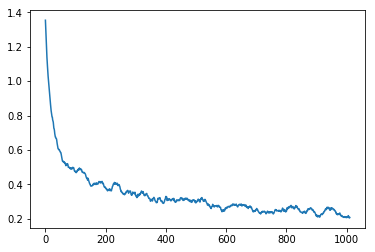

In [26]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 93.93%


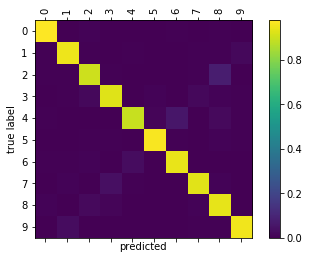

In [24]:
from lib.evaluation import Evaluation
n_categories = 10
test_data = TwoStateMNISTData(test_set)
test_data.set_seq_length(min_length=1, max_length=3)

evaluation = Evaluation(net, test_data)
confusion = evaluation.multioutput_confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)